In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import smerf
from smerf.models import *
from smerf.textcolor_data import *
from smerf.eval import *
import smerf.explanations as saliency
import glob

CACHE_DIR = '../outputs/cache'
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
PLOT_DIR = '../outputs/plots'
if not os.path.exists(PLOT_DIR):
    os.mkdir(PLOT_DIR)
    
exp_no = 2
methods_name =  os.path.join(CACHE_DIR, 'methods_%0.2f.pkl'%exp_no)
methods = pickle.load(open(methods_name, 'rb'))
methods = [m[3] for m in methods][1:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def load_saliency_results(exp_no):
    result_name = os.path.join(CACHE_DIR, 'result_%0.2f.pkl'%exp_no)
    methods_name = os.path.join(CACHE_DIR, 'methods_%0.2f.pkl'%exp_no)
    data = pickle.load(open(result_name, 'rb'))
    methods = pickle.load(open(methods_name, 'rb'))
    return data, methods

def splitname2objcount(split_names):
    obj_count = []
    for k in sorted(split_names.keys()):
        c = split_names[k][0] + split_names[k][1]
        if split_names[k][2] == -1:
            obj_count.append(c)
        else:
            obj_count.append(c+1)
    return obj_count


meta_data = dict()
split_names = {}
patch = [0,1]
text = [-1,0,1]
switch = [0,1]
count = 0
for p in patch:
    for t in text:
        for s in switch:
            split_names[count] = (s, p, t)
            count += 1
ct = splitname2objcount(split_names)
meta_data[1.11] = {'no_split': 12, 
                   'split_names': split_names,
                   'no_test_per_split':500,
                   'obj_count':ct
                  }

split_names = dict()
switch = [0,1]
patch = [0,1]
text = [0,1]
count = 0
for s in switch:
    for p in patch:
        for t in text:
            split_names[count] = (s, p, t)
            count += 1
ct = splitname2objcount(split_names)
meta_data[2.11] = {'no_split': 8, 
                   'split_names': split_names,
                   'no_test_per_split':500,
                   'obj_count':ct
                  }

split_names = dict()
patch = [0,1]
text = [-1,0,1]
switch = [0,1]
count = 0
for p in patch:
    for t in text:
        for s in switch:
            split_names[count] = (s,p,t)
            count += 1
ct = splitname2objcount(split_names)
meta_data[1.20] = {'no_split': 12, 
                   'split_names': split_names,
                   'no_test_per_split':500,
                   'obj_count':ct
                  }

split_names = dict()
switch = [0,1]
patch = [0,1]
text = [-1,0,1]
count = 0
for s in switch:
    for p in patch:
        for t in text:
            if t == -1 and s == 0: # undecided regions
                continue
            split_names[count] = (s, p, t)
            count += 1
ct = splitname2objcount(split_names)
meta_data[3.71] = {'no_split': 10, 
                   'split_names': split_names,
                   'no_test_per_split':400,
                   'obj_count':ct
                  }

split_names = dict()
switch = [0,1]
patch = [0,1]
text = [-1,0,1]
count = 0
for s in switch:
    for p in patch:
        for t in text:
            if t == -1 and p == 0: # undecided regions
                continue
            split_names[count] = (s, p, t)
            count += 1
ct = splitname2objcount(split_names)
meta_data[3.72] = {'no_split': 10, 
                   'split_names': split_names,
                   'no_test_per_split':400,
                   'obj_count':ct
                  }

split_names = dict()
switch = [0,1]
patch = [0,1]
text = [-1,0,1]
count = 0
for s in switch:
    for p in patch:
        for t in text:
            if t == -1 and s == 1: # undecided regions
                continue
            split_names[count] = (s, p, t)
            count += 1
ct = splitname2objcount(split_names)
meta_data[3.73] = {'no_split': 10, 
                   'split_names': split_names,
                   'no_test_per_split':400,
                   'obj_count':ct
                  }

split_names = dict()
switch = [0,1]
patch = [0,1]
text = [-1,0,1]
count = 0
for s in switch:
    for p in patch:
        for t in text:
            if t == -1 and p == 1: # undecided regions
                continue
            split_names[count] = (s, p, t)
            count += 1
ct = splitname2objcount(split_names)
meta_data[3.74] = {'no_split': 10, 
                   'split_names': split_names,
                   'no_test_per_split':400,
                   'obj_count':ct
                  }


    
def plot_afl_change_obj(exp_no, meta_data, axs=None):
    p_results = []
    s_results = []
    for s in [exp_no]:
        bucket_results = sorted(glob.glob("../outputs/cache/metrics_weighted_%0.2f_*.npy"%(s)))
        ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
        for i in ids:
            d = np.load("../outputs/cache/metrics_weighted_%0.2f_%d.npy"%(s,i))
            bucket_p, bucket_s = d[0], d[2]
            p_results.append(bucket_p)
            s_results.append(bucket_s)
    p_results = np.array(p_results)
    p_results = np.nan_to_num(p_results, nan=-1)
    s_results = np.array(s_results)
    s_results = np.nan_to_num(s_results, nan=-1)
    
    md = meta_data[exp_no]
    obj_count = np.array(md['obj_count'])
    
    out1 = np.zeros((3, s_results.shape[1]))
    out2 = np.zeros((3, s_results.shape[1]))
    for i in [1,2,3]:
        bucket_ids = np.where(obj_count == i)[0]
        print(bucket_ids)
        arr1 = p_results[bucket_ids]
        arr1 = arr1[~(arr1 == -1).any(axis=1)]


        out1[i-1,:] = np.mean(arr1, axis=0)
        arr2 = s_results[bucket_ids]
        arr2 = arr2[~(arr1 == -1).any(axis=1)]
        print(arr1.shape, arr2.shape)
        out2[i-1,:] = np.mean(arr2, axis=0)
        
        
    if axs == None:
        f, axs = plt.subplots(1,1, figsize=(5,2))
    axs.plot(out1[0], label='1', color='r')
    axs.plot(out1[1], label='2', color='b')
    axs.plot(out1[2], label='3', color='g') 

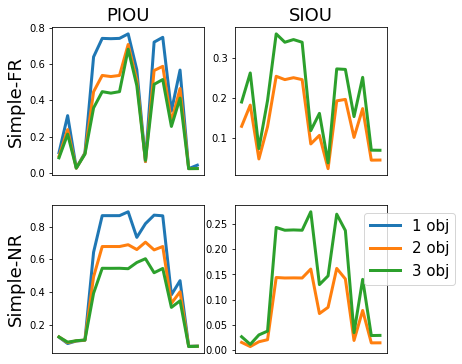

In [9]:
# plot decreasing PAFL and increasing SAFL as we increase the number of objects in the iamge.

f, axs = plt.subplots(2,2,figsize=(6,6))
exp_no = 1.11
bids = [[6], [7,8,10], [9,11]]
no_objs = [1,2,3]
p_results = []
s_results = []
bucket_results = sorted(glob.glob("../outputs/cache/metrics_weighted_%0.2f_*.npy"%(exp_no)))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
out_p = []
out_s = []
for bid in bids:
    p_results = []
    s_results = []
    for b in bid:
        d = np.load("../outputs/cache/metrics_weighted_%0.2f_%d.npy"%(exp_no,b))
        bucket_p, bucket_s = d[0], d[2]
        p_results.append(bucket_p)
        s_results.append(bucket_s)
    p_results = np.array(p_results)
    s_results = np.array(s_results)
    out_p.append(p_results)
    out_s.append(s_results)

pout = np.zeros((3, out_p[0].shape[-1]))
sout = np.zeros((3, out_p[0].shape[-1]))
for i in range(len(bids)):
    pval = np.mean(out_p[i], axis=0)
    sval = np.mean(out_s[i], axis=0)
    pout[i] = pval
    sout[i] = sval
    
# f, axs = plt.subplots(1,2,figsize=(6,2))
for i, n in enumerate(no_objs):
    axs[0,0].plot(pout[i], label=str(n)+' obj', linewidth=3)
    axs[0,1].plot(sout[i], label=str(n)+' obj',linewidth=3)
axs[0,0].set_xticks(())
axs[0,0].set_title('PAFL', fontsize=18)
axs[0,1].set_title('SAFL', fontsize=18)

axs[0,1].set_xticks(())
#axs[0,1].legend(loc='upper left',  bbox_to_anchor=(1, 1))
axs[0,0].set_ylabel('Simple-FR', fontsize=18)

exp_no = 2.11
bids = [[0,1], [2,3,4,5], [6,7]]
no_objs = [1,2,3]
p_results = []
s_results = []
bucket_results = sorted(glob.glob("../outputs/cache/metrics_weighted_%0.2f_*.npy"%(exp_no)))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
out_p = []
out_s = []
for bid in bids:
    p_results = []
    s_results = []
    for b in bid:
        d = np.load("../outputs/cache/metrics_weighted_%0.2f_%d.npy"%(exp_no,b))
        bucket_p, bucket_s = d[0], d[2]
        p_results.append(bucket_p)
        s_results.append(bucket_s)
    p_results = np.array(p_results)
    s_results = np.array(s_results)
    out_p.append(p_results)
    out_s.append(s_results)

pout = np.zeros((3, out_p[0].shape[-1]))
sout = np.zeros((3, out_p[0].shape[-1]))
for i in range(len(bids)):
    pval = np.mean(out_p[i], axis=0)
    sval = np.mean(out_s[i], axis=0)
    pout[i] = pval
    sout[i] = sval
    
#f, axs = plt.subplots(1,2,figsize=(6,2))
for i, n in enumerate(no_objs):
    axs[1,0].plot(pout[i], label=str(n)+' obj', linewidth=3)
    axs[1,1].plot(sout[i], label=str(n)+' obj',linewidth=3)
axs[1,0].set_xticks(())
axs[1,1].set_xticks(())
axs[1,1].legend(loc='upper left',  bbox_to_anchor=(0.8, 1), fontsize=15)
axs[1,0].set_ylabel('Simple-NR', fontsize=18)
plt.savefig('../outputs/plots/obj.pdf', dpi=200, bbox_inches='tight')

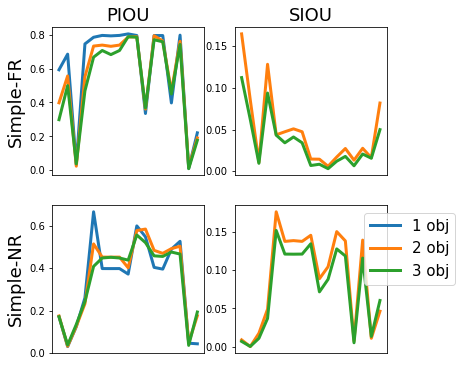

In [10]:
# TODO plot decreasing PAFL and increasing SAFL as we increase the number of objects in the iamge.

f, axs = plt.subplots(2,2,figsize=(6,6))
exp_no = 1.11
bids = [[6], [7,8,10], [9,11]]
no_objs = [1,2,3]
p_results = []
s_results = []
bucket_results = sorted(glob.glob("../outputs/cache/metrics_plain_single_%0.2f_*.npy"%(exp_no)))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
out_p = []
out_s = []
for bid in bids:
    p_results = []
    s_results = []
    for b in bid:
        d = np.load("../outputs/cache/metrics_plain_single_%0.2f_%d.npy"%(exp_no,b))
        bucket_p, bucket_s = d[0], d[2]
        p_results.append(bucket_p)
        s_results.append(bucket_s)
    p_results = np.array(p_results)
    s_results = np.array(s_results)
    out_p.append(p_results)
    out_s.append(s_results)

pout = np.zeros((3, out_p[0].shape[-1]))
sout = np.zeros((3, out_p[0].shape[-1]))
for i in range(len(bids)):
    pval = np.mean(out_p[i], axis=0)
    sval = np.mean(out_s[i], axis=0)
    pout[i] = pval
    sout[i] = sval
    
# f, axs = plt.subplots(1,2,figsize=(6,2))
for i, n in enumerate(no_objs):
    axs[0,0].plot(pout[i], label=str(n)+' obj', linewidth=3)
    axs[0,1].plot(sout[i], label=str(n)+' obj',linewidth=3)
axs[0,0].set_xticks(())
axs[0,0].set_title('PIOU', fontsize=18)
axs[0,1].set_title('SIOU', fontsize=18)
axs[0,1].set_xticks(())
#axs[0,1].legend(loc='upper left',  bbox_to_anchor=(1, 1))
axs[0,0].set_ylabel('Simple-FR', fontsize=18)

exp_no = 2.11
bids = [[0,1], [2,3,4,5], [6,7]]
no_objs = [1,2,3]
p_results = []
s_results = []
bucket_results = sorted(glob.glob("../outputs/cache/metrics_plain_single_%0.2f_*.npy"%(exp_no)))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
out_p = []
out_s = []
for bid in bids:
    p_results = []
    s_results = []
    for b in bid:
        d = np.load("../outputs/cache/metrics_plain_single_%0.2f_%d.npy"%(exp_no,b))
        bucket_p, bucket_s = d[0], d[2]
        p_results.append(bucket_p)
        s_results.append(bucket_s)
    p_results = np.array(p_results)
    s_results = np.array(s_results)
    out_p.append(p_results)
    out_s.append(s_results)

pout = np.zeros((3, out_p[0].shape[-1]))
sout = np.zeros((3, out_p[0].shape[-1]))
for i in range(len(bids)):
    pval = np.mean(out_p[i], axis=0)
    sval = np.mean(out_s[i], axis=0)
    pout[i] = pval
    sout[i] = sval
    
#f, axs = plt.subplots(1,2,figsize=(6,2))
for i, n in enumerate(no_objs):
    axs[1,0].plot(pout[i], label=str(n)+' obj', linewidth=3)
    axs[1,1].plot(sout[i], label=str(n)+' obj',linewidth=3)
axs[1,0].set_xticks(())
#axs[1,0].set_title('PAFL', fontsize=18)
#axs[1,1].set_title('SAFL', fontsize=18)
axs[1,1].set_xticks(())
axs[1,1].legend(loc='upper left',  bbox_to_anchor=(0.8, 1), fontsize=15)
axs[1,0].set_ylabel('Simple-NR', fontsize=18)
plt.savefig('../outputs/plots/obj_plain_single.pdf', dpi=200, bbox_inches='tight')